<a href="https://colab.research.google.com/github/maryam-sabet/Voting_lungCT_Segmentation_With_UNET_DifferentBackbone_Models/blob/main/3)_Train_UNET_MODELS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Change directory to your project folder
%cd "/content/drive/MyDrive/segmentationn"

/content/drive/MyDrive/segmentationn


"**I changed** *keras.utils.generic_utils.get_custom_objects().update(custom_objects)* **to** *keras.utils.get_custom_objects().update(custom_objects)*
in .../lib/python3.6/site-packages/efficientnet/__init__.py **and it solved the issue.**"

#**Libraries**

In [ ]:
#Import library
import numpy as np
import pandas as pd
import cv2
import glob
import imageio
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
import segmentation_models as sm
import keras
from tensorflow.keras.callbacks import ModelCheckpoint , CSVLogger , LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16,DenseNet169,Xception,MobileNet,MobileNetV2,NASNetMobile,EfficientNetB0,DenseNet121,EfficientNetV2B0,ResNet50V2



# **Loading Data**

In [ ]:
Data = np.load ("/content/drive/MyDrive/segmentationn/dataset/data.npy")
Mask = np.load ("/content/drive/MyDrive/segmentationn/dataset/mask.npy")

In [ ]:
# Convert data types to float32
Data=Data.astype("float32")
Mask=Mask.astype("float32")

# Normalize mask data
Mask=Mask/255

In [ ]:
print(Data.dtype)
print(Mask.dtype)

float32
float32


In [ ]:
print(len(Data) ,len(Mask))

1657 1657


In [ ]:
print(Data.shape,Mask.shape)

(1657, 224, 224, 3) (1657, 224, 224, 3)


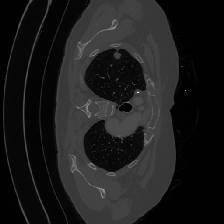

In [ ]:
# Display sample images
cv2_imshow(Data[10])

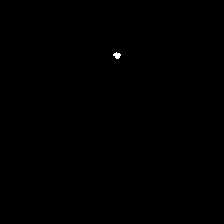

In [ ]:
cv2_imshow(Mask[10]*255)

**Split the data into train and test sets**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(Data, Mask, test_size=0.2, random_state=42)

 **Free up memory**

In [ ]:
del Data,Mask

In [ ]:
print("Train" , X_train.shape, y_train.shape)
print("Test",X_test.shape,  y_test.shape)

Train (1325, 224, 224, 3) (1325, 224, 224, 3)
Test (332, 224, 224, 3) (332, 224, 224, 3)


In [ ]:
# helper function for data visualization
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

#**Model**

In [ ]:
BACKBONE = 'densenet121'
BATCH_SIZE = 8
LR = 0.0001
EPOCHS = 20

# Preprocessing input data
preprocess_input = sm.get_preprocessing(BACKBONE)

In [ ]:
n_classes = 1
activation = 'sigmoid'

# Create the segmentation model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

29084464/29084464 [==============================] - 0s 0us/step


In [ ]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)


In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['input_4[0][0]']                
                                3)                                                                
                                                                                                  
 conv1/conv (Conv2D)            (None, None, None,   9408        ['zero_padding2d[0][0]']         
                                64)                                                         

In [ ]:
model_save = ModelCheckpoint("/content/drive/MyDrive/segmentationn/save_model/densenet121.h5" , save_best_only=True , verbose=2 , monitor="val_iou_score" , mode="max" )
csv_loger = CSVLogger("/content/drive/MyDrive/segmentationn/save_model/densenet121.csv" , append=True)

In [ ]:
H = model.fit(X_train,y_train, epochs=EPOCHS, callbacks=[model_save, csv_loger] ,
         validation_data=(X_test,y_test) , shuffle=False, batch_size=BATCH_SIZE)

Epoch 1/20
166/166 [==============================] - ETA: 0s - loss: 1.1035 - iou_score: 0.0558 - f1-score: 0.0904
Epoch 1: val_iou_score improved from -inf to 0.06815, saving model to /content/drive/MyDrive/segmentationn/save_model/densenet121.h5
166/166 [==============================] - 63s 258ms/step - loss: 1.1035 - iou_score: 0.0558 - f1-score: 0.0904 - val_loss: 1.0612 - val_iou_score: 0.0682 - val_f1-score: 0.1220
Epoch 2/20
166/166 [==============================] - ETA: 0s - loss: 1.0088 - iou_score: 0.2840 - f1-score: 0.4156
Epoch 2: val_iou_score improved from 0.06815 to 0.29536, saving model to /content/drive/MyDrive/segmentationn/save_model/densenet121.h5
166/166 [==============================] - 35s 213ms/step - loss: 1.0088 - iou_score: 0.2840 - f1-score: 0.4156 - val_loss: 1.0076 - val_iou_score: 0.2954 - val_f1-score: 0.4429
Epoch 3/20
166/166 [==============================] - ETA: 0s - loss: 0.9857 - iou_score: 0.4010 - f1-score: 0.5609
Epoch 3: val_iou_score impr

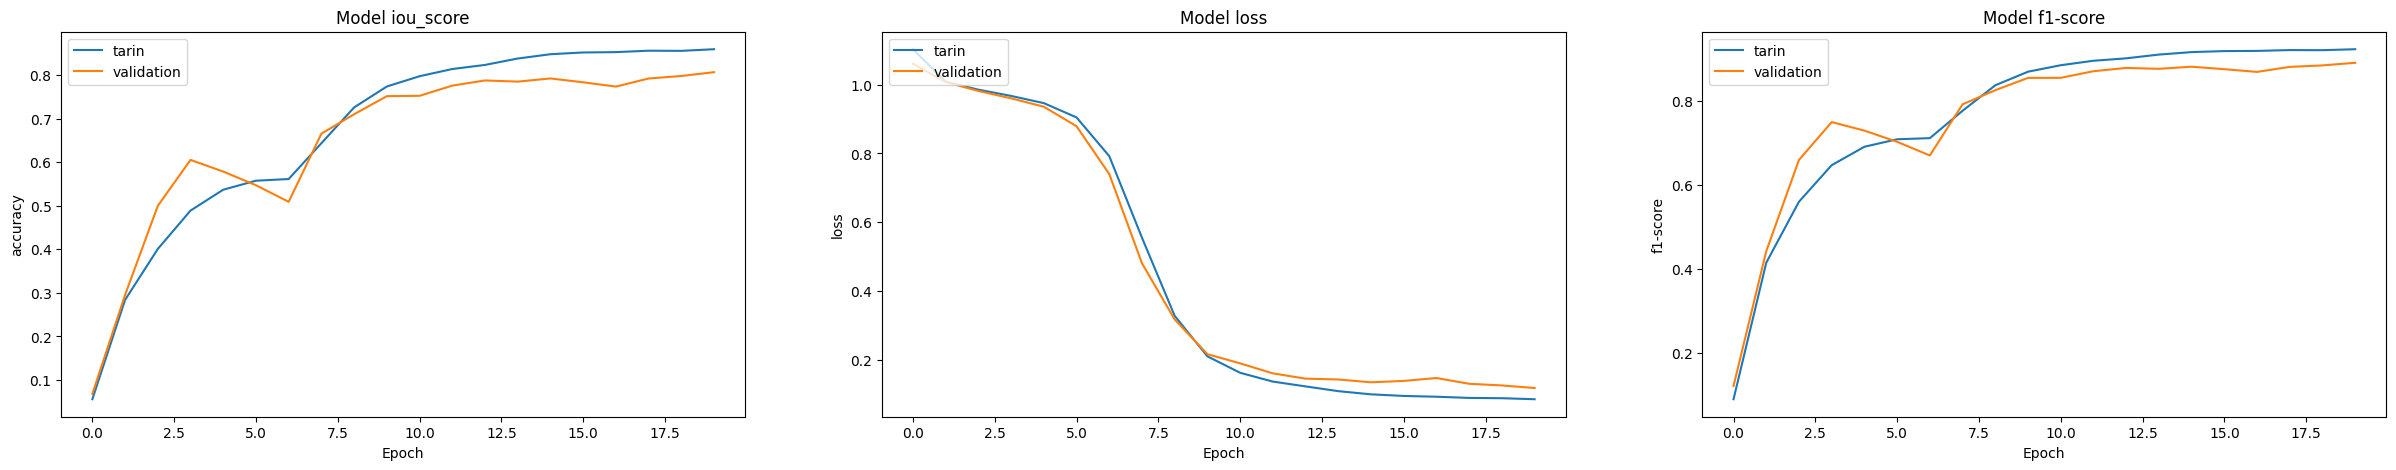

In [ ]:
# Plot training history
plt.figure(figsize=(30,5))
plt.subplot(131)
plt.plot(H.history['iou_score'])
plt.plot(H.history['val_iou_score'])
plt.title("Model iou_score")
plt.ylabel("accuracy")
plt.xlabel("Epoch")
plt.legend(['tarin', "validation"] , loc="upper left")
plt.subplot(132)
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title("Model loss")
plt.ylabel("loss")
plt.xlabel("Epoch")
plt.legend(['tarin', "validation"] , loc="upper left")
plt.subplot(133)
plt.plot(H.history['f1-score'])
plt.plot(H.history['val_f1-score'])
plt.title("Model f1-score")
plt.ylabel("f1-score")
plt.xlabel("Epoch")
plt.legend(['tarin', "validation"] , loc="upper left")
plt.show()

#**Test Prediction**

In [ ]:
# Load the trained model
model = tf.keras.models.load_model("/content/drive/MyDrive/segmentationn/save_model/densenet121.h5",
                                   custom_objects={"dice_loss_plus_1binary_focal_loss":total_loss, "iou_score":metrics , "f1-score":metrics})

In [ ]:
# Display the shape of the test data
X_test.shape

(332, 224, 224, 3)

In [ ]:
len(pr_mask)

332

In [ ]:
len(y_test)

332

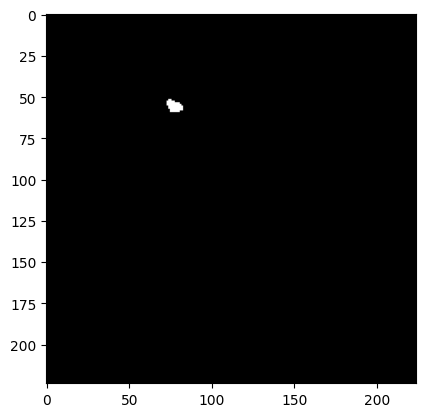

In [ ]:
plt.imshow(pr_mask[10],"gray")

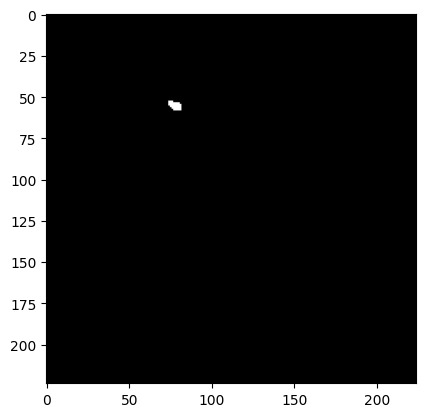

In [ ]:
plt.imshow(y_test[10])

In [ ]:
np.unique(y_test[5])

array([0., 1.], dtype=float32)

In [ ]:
np.unique(pr_mask[5])

array([0., 1.], dtype=float32)

In [ ]:
print(pr_mask.shape)
print(y_test.shape)

In [ ]:
# Convert prediction mask to RGB
new_pr_mask=[]

for img in pr_mask:
    new_img= np.concatenate((img,img,img), axis=-1)      #(224,224,1) (224,224,1) (224,224,1)   (224,224,3)
    new_pr_mask.append(new_img)

new_pr_mask=np.array(new_pr_mask)

In [ ]:
# Flatten the test and prediction masks
y=y_test.flatten()
p=new_pr_mask.flatten()
print(y.shape , p.shape)

In [ ]:
from sklearn.metrics import precision_score , recall_score , f1_score , confusion_matrix , ConfusionMatrixDisplay ,classification_report
precision = precision_score(y , p )
print(precision*100)

In [ ]:
recal = recall_score(y , p )
print(recal*100)

In [ ]:
f1 = f1_score(y , p )
print(f1*100)

In [ ]:
print(classification_report(y , p ))